In [33]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [837]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

In [1164]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
#     ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j + N_2_j > 0))[0]
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j))  # N_j
    
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = O_j/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = N_j/(N_1_j*N_2_j)
#     var = np.trapz((res[:, 0] * res[:, 0] * res[:, 2]), bins[ind])
#     num = np.trapz((res[:, 0] * res[:, 1]), bins[ind])
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()
    
    if var == 0:
        return 0
    stat_val = np.power(num, 2) / var
    
#     var2 = (res[::-1, 0] * res[::-1, 0] * res[:, 2]).sum()
#     num2 = (res[::-1, 0] * res[:, 1]).sum()
#     stat_val += np.power(num2, 2) / var2

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, 
                     weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)
        
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                            time_hist_2.astype("float32"),
                            cens_hist_1.astype("float32"),
                            cens_hist_2.astype("float32"),
                            np.uint32(weightings),
                            weights_hist.astype("float32")
                           ) 
        return logrank
    except Exception as err:
        print(err)
        return 0.0

    
def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
                              apr_t_distr, apr_e_distr, l_reg):
    none_to = 0
    max_stat_val = 1.0
    
#     n1 = np.cumsum(left_time_hist[::-1])[::-1] + 1
#     n2 = np.cumsum(right_time_hist[::-1])[::-1] + 1
#     cf = n1/(n1 + n2)
    cf = 0.5
    
#     n1 = np.sum(left_time_hist)
#     n2 = np.sum(right_time_hist)
#     cf = n1/(n1 + n2)
    
#     ev = np.sum(left_cens_hist + right_cens_hist)
#     ev_cf = ev/(n1 + n2)
#     lstd = np.std(np.repeat(np.arange(left_time_hist.size), left_time_hist.astype(int)))
#     rstd = np.std(np.repeat(np.arange(right_time_hist.size), right_time_hist.astype(int)))
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + na_cens_hist + l_reg*apr_e_distr*cf, 
                             right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + na_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + l_reg*apr_e_distr*cf,
                             right_cens_hist + na_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf,
                                        right_time_hist + l_reg*apr_t_distr*(1 - cf),
                                        left_cens_hist + l_reg*apr_e_distr*cf, 
                                        right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh, stat_diff=None):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    attrs["stat_diff"] = stat_diff 
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):  
#     print(sorted([np.round(x["stat_diff"], 3) for x in attr_dicts]))
    
    attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts)//2)]
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts) - 2)]
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]))[:max(1, len(attr_dicts)//2)]
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
                                                                       
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        best_attr["src_val"] = best_attr['values']
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def split_time_to_bins(time, apr_times=None):
#     if apr_times is None:
#         return np.searchsorted(np.unique(time), time)
#     return np.searchsorted(np.unique(apr_times), time)
#     return np.searchsorted(np.quantile(apr_times, np.arange(6)/5), time)
    if apr_times is None:
        return np.searchsorted(np.arange(int(time.min() - 1), int(time.max() + 1)), time)
    return np.searchsorted(np.arange(int(apr_times.min() - 1), int(apr_times.max() + 1)), time)


def ranksums_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    s = np.dot(x, rank)
#     print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

def diptest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, diptest.dipstat(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, diptest.dipstat(t2))
    return res

def stdtest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, t1.std())
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, t2.std())
    return res

def iqrtest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, stats.iqr(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, stats.iqr(t2))
    return res


def count_sf_diff(time, cens):
    c_time = np.cumsum(time[::-1])[::-1]
    sf = np.cumprod((1.0 - cens / (c_time + 1)))
    sf[c_time == 0] = 0.0
    return np.sum((sf - 0.5)**2) / sf.shape[0] # max(1, bins[-1] - bins[0])

def cnttest_hist(time_1, cens_1, time_2, cens_2):
    d1 = count_sf_diff(time_1, cens_1)
    d2 = count_sf_diff(time_2, cens_2)
    return min(d1, d2)

def inverse_bincount_sf(time_hist, cens_hist):
    evs = np.repeat(np.arange(1, time_hist.size + 1), cens_hist)
    cns = np.repeat(np.arange(1, time_hist.size + 1), time_hist - cens_hist)
    
    return get_y(time=np.hstack([evs, cns]),
               cens=np.hstack([np.ones_like(evs), np.zeros_like(cns)]))

def ibstest_hist(time_1, cens_1, time_2, cens_2, bins):
    y_1 = inverse_bincount_sf(time_1.astype(int), cens_1.astype(int))
    y_2 = inverse_bincount_sf(time_2.astype(int), cens_2.astype(int))
    
    sf_1 = np.cumprod((1.0 - cens_1 / (time_1 + 1)))
    sf_2 = np.cumprod((1.0 - cens_2 / (time_2 + 1)))
    
    sf_1 = np.repeat(sf_1[np.newaxis, :], y_1.shape[0], axis=0)
    sf_2 = np.repeat(sf_2[np.newaxis, :], y_2.shape[0], axis=0)
    
    ibs_1 = metr.ibs_remain(y_1, y_1, sf_1, bins)
    ibs_2 = metr.ibs_remain(y_2, y_2, sf_2, bins)
    return max(ibs_1, ibs_2)

def peaktest_hist(x, y):
    return max(max_width_peaks(x), max_width_peaks(y))

def mw_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    R1 = np.dot(x, rank)
    U1 = R1 - n1*(n1+1)/2
    U2 = n1 * n2 - U1

    U = np.maximum(U1, U2)
    return U

def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, 
                         apr_time=None, apr_event=None, l_reg=0, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    if np.sum(cens) == 0:
        return best_attr
    if weights is None:
        weights = np.ones_like(dur)
        
    weights_hist = None
    # time_bins = np.arange(int(dur.min() - 1), int(dur.max() + 1)) 
    dur = split_time_to_bins(dur, apr_time)
    
#     if apr_time is None:
#         dur = split_time_to_bins(dur) #, apr_time)
#     else:
#         apr_time_1 = split_time_to_bins(apr_time, dur) #, apr_time)
#         dur = split_time_to_bins(dur)
    
    if apr_time is None:
#         time_bins = np.arange(int(dur.min() - 1), int(dur.max() + 1)) # np.unique(dur)
        max_bin = dur.max()
        apr_t_distr = np.zeros(max_bin + 1)
        apr_e_distr = np.zeros(max_bin + 1)
    else:
        #time_bins = np.arange(int(apr_time.min() - 1), int(apr_time.max() + 1)) # np.unique(apr_time)
        apr_time_1 = split_time_to_bins(apr_time, apr_time)
        max_bin = apr_time_1.max()
        apr_t_distr, apr_e_distr = get_sa_hists(apr_time_1, apr_event, minlength=max_bin + 1)
    
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    weights_notna = weights[~ind]

    dis_coef = 1
    if balance:
        dis_coef = (cens.shape[0] - np.sum(cens)) / np.sum(cens)

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights_notna)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)
    l_cens_hist = l_time_hist.copy()
    
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        weights_hist = ibs_WW(y_, y_, sf, dd, axis=0)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "weights":
        weights_hist = np.bincount(dur, weights=weights,
                                   minlength=max_bin + 1)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]

        weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    
    for u in np.unique(index_vals_bin):
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights_notna[curr_mask])
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
            
#         plt.plot(l_time_hist)
#         plt.plot(r_time_hist)
#         plt.plot(apr_t_distr)
#         plt.show()
        
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
            apr_t_distr, apr_e_distr, l_reg)
        
        if max_stat_val > signif_stat:
            stat_diff = 1
#             if na_time_hist.shape[0] > 0:
#                 stat_diff = diptest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
#                                          (r_time_hist + none_to*na_time_hist))
#             else:
#                 stat_diff = diptest_hist(l_time_hist,
#                                          r_time_hist)

            if na_time_hist.shape[0] > 0:
                stat_diff = cnttest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
                                         (l_cens_hist + (1 - none_to)*na_cens_hist), 
                                         (r_time_hist + none_to*na_time_hist),
                                         (r_cens_hist + none_to*na_cens_hist))
            else:
                stat_diff = cnttest_hist(l_time_hist, l_cens_hist, r_time_hist, r_cens_hist)
    
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan, stat_diff)
            attr_dicts.append(attr_loc)
            
#     attr_dicts = list(filter(lambda x: x["stat_diff"] < 0.5, attr_dicts))
    if len(attr_dicts) == 0:
            return best_attr
    
#     if na_time_hist.shape[0] > 0:
#         sh_diff = count_sf_diff(r_time_hist + l_time_hist + na_time_hist, 
#                                 r_cens_hist + l_cens_hist + na_cens_hist)
#     else:
#         sh_diff = count_sf_diff(r_time_hist + l_time_hist, 
#                                 r_cens_hist + l_cens_hist)
    
# #     plt.hist([v["stat_diff"] for v in attr_dicts])
# #     xmin, xmax, ymin, ymax = plt.axis()
    
# #     plt.vlines([sh_diff], ymin=0, ymax=ymax, color="red")
# #     plt.show()
#     attr_dicts = list(filter(lambda x: x["stat_diff"] > sh_diff/2, attr_dicts))
#     if len(attr_dicts) == 0:
#         return best_attr
    
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [1165]:
attr_dicts = [{"a": 1}, {"a": 0.4}, {"a": 0.3}, {"a": 0.1}, {"a": 5}, {"a": 8}]

sorted(attr_dicts, key=lambda x: abs(x["a"]), reverse=True)[:max(1, len(attr_dicts)//2)]
# list(filter(lambda x: x["a"] > 3, attr_dicts))

[{'a': 8}, {'a': 5}, {'a': 1}]

In [1166]:
from survivors.tree.node import Node, Rule
from survivors.tree import CRAID

class Node1(Node):
    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}
        attr = max(attrs, key=lambda x: attrs[x]["stat_val"])
#         attrs_gr = dict(filter(lambda x: x[1]["sign_split"] > 0, attrs.items()))
#         if len(attrs_gr) == 0:
#             attr = min(attrs, key=lambda x: attrs[x]["p_value"])
#         else:
#             attr = min(attrs_gr, key=lambda x: attrs_gr[x]["p_value"])
#             if self.info["bonf"]:
#                 attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]

#         if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:  # suffix for simple p-value
#             attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        
        return (attr, attrs[attr])
    
    def split(self):
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        
        attr, best_split = self.find_best_split()
        
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges
        if self.verbose > 0:
            print('='*6, best_split["p_value"], attr)

        branch_ind = self.ind_for_nodes(self.df[attr], best_split, attr in self.categ)

        for n_b in np.unique(branch_ind):
            rule = Rule(feature=attr,
                        condition=best_split["values"][n_b],
                        has_nan=best_split["pos_nan"][n_b])
            d_node = self.df[branch_ind == n_b].copy()
            N = Node1(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth + 1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        if self.rule_edges.shape[0] == 1:
            print(branch_ind, self.df[attr], best_split, attr in self.categ)
            raise ValueError('ERROR: Only one branch created!')

        return node_edges

class CRAID1(CRAID):
    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01
        if isinstance(self.info["min_samples_leaf"], float):
            self.info["min_samples_leaf"] = max(int(self.info["min_samples_leaf"] * X_tr.shape[0]), 1)

        cnt.set_seed(self.random_state)

        if self.balance in ["balance", "balance+correct"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()
            self.correct_proba = freq[1] / (freq[1] + freq[0])  # or freq[1] / (freq[0])

            X_tr = get_oversample(X_tr, target=cnt.CENS_NAME)
        elif self.balance in ["balance+weights"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()

            X_tr["weights_obs"] = np.where(X_tr[cnt.CENS_NAME], freq[0] / freq[1], 1)
            self.info["weights_feature"] = "weights_obs"
        elif self.balance in ["too_late"]:
            y_tr["cens"][y_tr["time"] > np.quantile(y_tr["time"], 0.7)] = False
            
        elif self.balance in ["only_log_rank"]:
            self.info["balance"] = True

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node1(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

        return

In [1167]:
class BootstrapCRAID1(BootstrapCRAID):
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.y_train = y
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_cr = cnt.pd_to_xy(x_sub)

            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_cr)

            self.add_model(model, x_oob)
        print(f"fitted: {len(self.models)} models.")

In [1168]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]
            
            model = CRAID1(features=self.features, apr_time=y_sub_tr["time"].copy(), apr_event=y_sub_tr["cens"].copy(),
                           random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_sf = metr.auprc(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(ibs_sf)
        wei = 1 - ibs_sf
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # self.weights += wei_i
        pass

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs", axes=None):
        print(label)
        res = []
        metr_vals = []
        q = [0.05, 0.25, 0.5, 0.75, 0.95]
        quantiles = []
        
        for i in range(len(self.models)):
            if metric == "IAUC_WW_TI":
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="hazard"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                
                metr_vals.append(metr.iauc_WW_TI(self.y_train, y_tmp, res_all, bins))
            elif metric == "CI_CENS":
                res.append(self.models[i].predict(X_tmp, target="time"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])

                metr_vals.append(concordance_index(y_tmp[cnt.TIME_NAME], res_all, y_tmp[cnt.CENS_NAME]))
            else:
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                res_all[:, -1] = 0
                res_all[:, 0] = 1

                if metric == "AUPRC":
                    metr_by_obs = metr.auprc(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_WW":
                    metr_by_obs = metr.ibs_WW(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_REMAIN":
                    metr_by_obs = metr.ibs_remain(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_remain(self.y_train, y_tmp, res_all, bins))
                quantiles.append(np.quantile(metr_by_obs, q))
        
        if axes is None:
            fig, axes = plt.subplots(ncols=2)
            axes[0].plot(range(len(self.models)), metr_vals, label=label)
            axes[1].plot(np.hstack([quantiles]), label=q)
            axes[1].legend()
        else:
            plt.plot(range(len(self.models)), metr_vals, label=label)
            plt.xlabel("Size of ensemble")
            plt.ylabel(metric)

(0.06295756096624644, 0.11184210526315788)

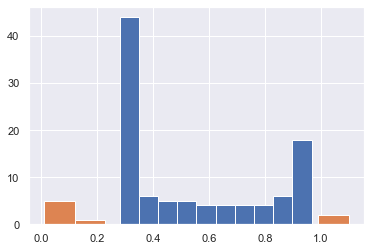

In [951]:
from scipy import stats

src = np.array([1, 2, 3, 3, 10, 15, 100, 110])/100
kde1 = stats.gaussian_kde(src)
x1 = np.linspace(0, 1, 100)
y1 = kde1.pdf(x1)

plt.hist(y1)
plt.hist(src)
diptest.dipstat(y1), diptest.dipstat(src)

In [676]:
bstr.models[0].nodes[16].leaf_model.lists['time']

[1701.0, 1701.0, 552.0, 2030.0, 552.0, 449.0, 1306.0, 1013.0, 1306.0]

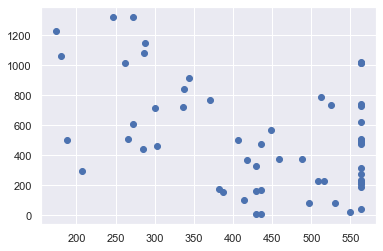

In [700]:
cnt_dist = []
dip_stat = []

for k, n in bstr.models[0].nodes.items():
    if not(n.is_leaf):
        continue
#     print(k)
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
# #     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {stats.iqr(n.leaf_model.lists['time'])}")
#     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {np.sum((sf - 0.5)**2)}")
# #     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {diptest.dipstat(n.leaf_model.lists['time'])}")
#     plt.legend()
#     plt.show()
    
    cnt_dist.append(np.sum((sf - 0.5)**2))
    dip_stat.append(stats.iqr(n.leaf_model.lists['time']))

plt.scatter(cnt_dist, dip_stat)

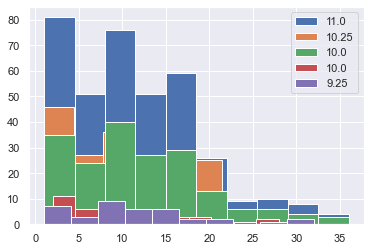

In [618]:
plt.hist(y["time"], label=f"{stats.iqr(y['time'])}")
plt.hist(y["time"][::2], label=f"{stats.iqr(y['time'][::2])}")
plt.hist(y["time"][1::2], label=f"{stats.iqr(y['time'][1::2])}")
plt.hist(y["time"][::10], label=f"{stats.iqr(y['time'][::10])}")
plt.hist(y["time"][1::10], label=f"{stats.iqr(y['time'][1::10])}")
plt.legend()

Text(0.5, 1.0, '0.08333333333333333')

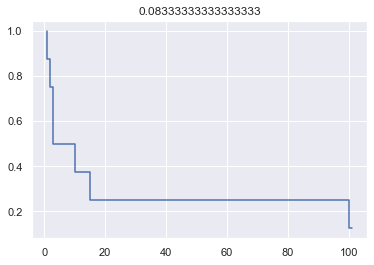

In [599]:
src = np.array([1, 2, 3, 3, 10, 15, 100])
a = random.choice(src)
n = np.cumsum(np.bincount(a)[::-1])[::-1]
o = np.bincount(a)
st = np.cumprod(1 - o/(n + 1))
plt.step(np.arange(a.min(), a.max()+2), st)
plt.title(diptest.dipstat(a))

In [1169]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# y["time"] += 1

# # y["cens"] = ~y["cens"]
# features = list(set(features) - {"max_2019_nCoV_nucleic_acid_detection", 
#                                  "mean_2019_nCoV_nucleic_acid_detection", 
#                                  "min_2019_nCoV_nucleic_acid_detection"})
# X = X[features]

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

In [1170]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}


bstr = BootstrapCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO,
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.2257 0.2247 0.2187 0.2065 0.1887 0.1859 0.1782 0.1708 0.169  0.1669
 0.1668 0.1651 0.1634 0.1634 0.1635 0.1635 0.1634 0.1635 0.1623 0.1631
 0.1639 0.1633 0.1639 0.1638 0.1639 0.1636 0.1642 0.1639 0.1639 0.1632
 0.1626 0.1622 0.1618 0.1612 0.1615 0.1619 0.1613 0.1612 0.1606 0.1606
 0.1606 0.1603 0.1602 0.16   0.1598 0.1597 0.1593 0.1595 0.1597 0.1598]
fitted: 47 models.
[0.62407661 0.13910346 0.34133729 0.77522468 0.69598384 0.52368669
 0.6764658 ]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.63068204 0.13943861 0.34146646 0.77485602 0.69517524 0.5154209
 0.67481244]

In [ ]:
[0.62872777 0.14054648 0.36158996 0.77728187 0.69203627 0.52087535
 0.67264695]

[0.62524917 0.14514113 0.34624358 0.761493   0.68754661 0.50908235
 0.66732996]

In [ ]:
[0.7692255  0.07045393 0.12963503 0.88939764 0.75177913 0.53243214
 0.73848537]

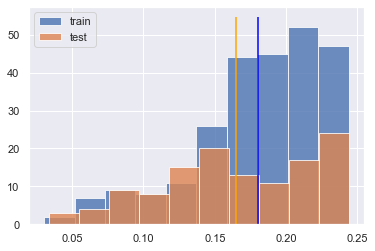

In [1090]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

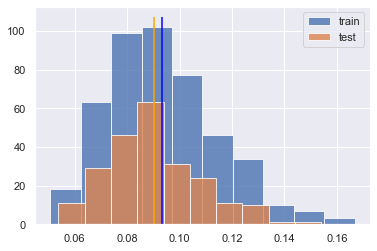

In [1004]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

In [ ]:
[0.76360521 0.07304893 0.13299682 0.86558123 0.75005898 0.52793664
 0.73659702]

In [ ]:
[0.76387937 0.07364383 0.13161974 0.88202971 0.74879034 0.52826713
 0.73542529]

In [ ]:
[0.62474106 0.14258534 0.35411988 0.76309402 0.6937536  0.51879583
 0.67393416]

In [ ]:
[0.6246238  0.1413695  0.35526522 0.76653645 0.69048486 0.51676118
 0.67080522]

[0.62481923 0.14399089 0.33614265 0.76982147 0.68980032 0.50977725
 0.66940708]

In [ ]:
[0.74571624 0.07691478 0.13562212 0.85031324 0.74644416 0.51884859
 0.73265049]

In [ ]:
[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298]

In [1034]:
bstr.models[0].visualize(mode="surv")

In [ ]:
[0.75798492 0.07584531 0.15275895 0.84609398 0.74428908 0.52513036
 0.73100674]

In [ ]:
[0.76579849 0.0736009  0.13471011 0.85407327 0.74949491 0.52675405
 0.73599546] # rank timeline

In [ ]:
[0.75867032 0.07254859 0.1335381  0.84727707 0.7503295  0.53066127
 0.73701628] # minstd rank timeline

[0.75633996 0.07495719 0.13651817 0.83066202 0.7504991  0.53075341
 0.73718118] # minstd full timeline

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
#  0.73447933] # diptest rank timeline

[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298] # diptest full timeline

In [ ]:
[0.61622044 0.14232877 0.36427644 0.76000316 0.68964637 0.5158604
 0.66995968]

In [ ]:
[0.76662097 0.07352715 0.1427046  0.85226585 0.74681081 0.52533867
 0.73338826]

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
 0.73447933]

In [ ]:
[0.76031528 0.07545675 0.13330532 0.84776847 0.74616391 0.52064969
 0.73249638]

In [ ]:
[0.75222755 0.07254517 0.14051689 0.87888129 0.74781346 0.53118041
 0.73468419]
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]
[0.62798515 0.14223849 0.34295473 0.76877587 0.6948715  0.51542966
 0.67454411]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62778972 0.14300061 0.33354884 0.77477676 0.69121148 0.50949231
 0.6706261 ]

In [ ]:
[0.6281024  0.14091349 0.34395037 0.77027241 0.69435691 0.52027288
 0.67463645]

In [ ]:
[0.62614813 0.14374146 0.34480665 0.75541951 0.69278564 0.51871816
 0.67306706]

In [ ]:
[0.63091655 0.1422004  0.34096467 0.76252518 0.69420142 0.52163777
 0.67465319]

In [ ]:
[0.63162009 0.14071645 0.34137235 0.76280546 0.69149669 0.51923545
 0.67198272]

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_23760\1053756791.py:5: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))


Text(0, 0.5, 'Mean leaf time')

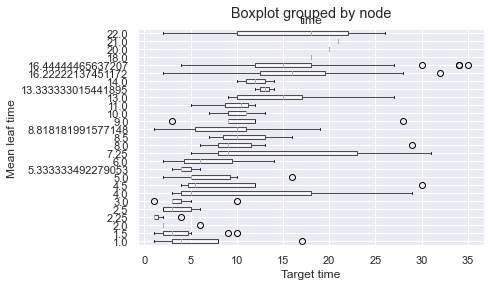

In [1157]:
ind = 0
pred_0_numb = bstr.models[ind].predict(X_tr, target="numb")
pred_0_time = bstr.models[ind].predict(X_tr, target="time")

a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))

dd_ = pd.DataFrame()
dd_["time"] = y_tr["time"]
dd_["node"] = pred_0_time
ax = dd_.boxplot(column='time', by='node', vert=False)
# ax.set_yticks(np.unique(pred_0_numb[~pd.isna(pred_0_numb)]))

# plt.scatter(y_tr["time"], pred_0_time, c=pred_0_numb)
# plt.hlines(y=[a], xmin=y_tr["time"].min(), xmax=y_tr["time"].max(), alpha=0.3)
plt.xlabel("Target time")
plt.ylabel("Mean leaf time")

In [322]:
np.unique(pred_0_numb)

array([ 4.,  8., 10., 12., 14., 15., 20., 28., 30., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 46., 47., 48., 52., 53.,
       55., 56., 57., 58.])

corr: -0.16900327660519382
p-value: 0.2786359397598851


C:\Users\vasiliev\AppData\Local\Temp\ipykernel_23760\3754810174.py:14: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))


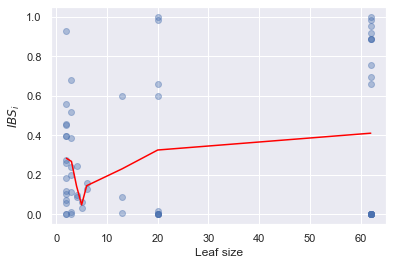

In [1094]:
from scipy.stats import spearmanr

X_ = X_HO.reset_index(drop=True)

ind = 0
X_sub = X_.loc[X_.index.difference(bstr.oob_index[ind]), :]
y_sub = y_tr[X_.index.difference(bstr.oob_index[ind])]

pred_0_time = bstr.models[ind].predict(X_sub, target="time")
pred_0_size = bstr.models[ind].predict(X_sub, target="size")
pred_0_surv = bstr.models[ind].predict_at_times(X_sub, bins=bins_HO, mode="surv")

ibss = metr.ibs_WW(y_tr, y_sub, pred_0_surv, bins_HO, axis=0)
a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))

plt.scatter(pred_0_size, ibss, alpha=0.4)
plt.plot(np.unique(pred_0_size), a[~np.isnan(a)], color="red")
plt.xlabel("Leaf size")
plt.ylabel(r"$IBS_i$")

rho, p = spearmanr(ibss[pred_0_size < 30], pred_0_size[pred_0_size < 30])
print("corr:", rho)
print("p-value:", p)

In [417]:
1/y_tr.shape[0]

0.00398406374501992

In [1171]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'aggreg_func': 'mean', 'all_weight': True, 'balance': None, 
              'categ': categ, "l_reg": 0.0,
              'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
              'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
              'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr = IBSCleverBoostingCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

UNIQUE (0):231, DIST: [189 132]
UNIQUE (1):237, DIST: [181 140]
UNIQUE (2):230, DIST: [181 140]
UNIQUE (3):228, DIST: [169 152]
UNIQUE (4):229, DIST: [177 144]
UNIQUE (5):237, DIST: [179 142]
UNIQUE (6):231, DIST: [190 131]
UNIQUE (7):232, DIST: [174 147]
UNIQUE (8):239, DIST: [188 133]
UNIQUE (9):231, DIST: [183 138]
UNIQUE (10):224, DIST: [185 136]
UNIQUE (11):220, DIST: [165 156]
UNIQUE (12):233, DIST: [180 141]
UNIQUE (13):236, DIST: [187 134]
UNIQUE (14):233, DIST: [169 152]
UNIQUE (15):228, DIST: [184 137]
UNIQUE (16):236, DIST: [181 140]
UNIQUE (17):236, DIST: [185 136]
UNIQUE (18):223, DIST: [188 133]
UNIQUE (19):230, DIST: [194 127]
UNIQUE (20):239, DIST: [186 135]
UNIQUE (21):231, DIST: [169 152]
UNIQUE (22):232, DIST: [177 144]
UNIQUE (23):232, DIST: [177 144]
UNIQUE (24):243, DIST: [179 142]
UNIQUE (25):231, DIST: [183 138]
UNIQUE (26):234, DIST: [192 129]
UNIQUE (27):235, DIST: [171 150]
UNIQUE (28):242, DIST: [182 139]
UNIQUE (29):235, DIST: [168 153]
UNIQUE (30):224, DIS

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.7692255  0.07245466 0.13178534 0.87165268 0.74902336 0.52570024
 0.73548862]

train
test


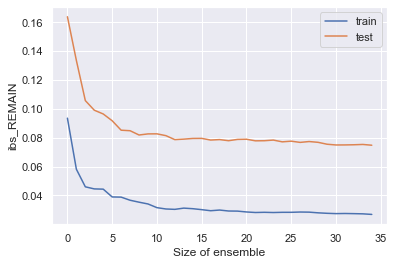

train
test


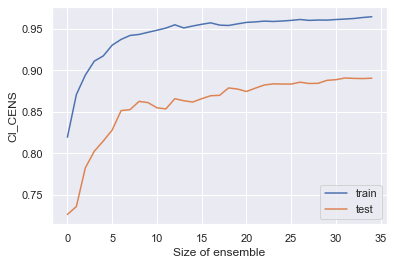

train
test


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\Program

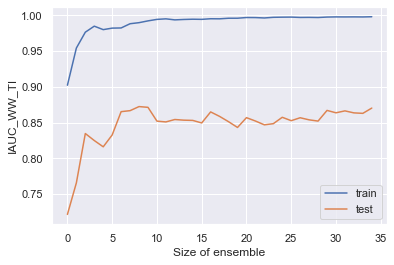

train
test


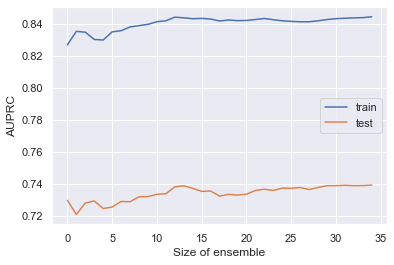

In [1162]:
axx = 1
for mtr in ["ibs_REMAIN", "CI_CENS", "IAUC_WW_TI", "AUPRC"]:
    bstr.plot_curve(X_tr, y_tr, bins_HO, "train", mtr, axes=axx)
    bstr.plot_curve(X_HO, y_HO, bins_HO, "test", mtr, axes=axx)
    plt.legend()
    plt.show()

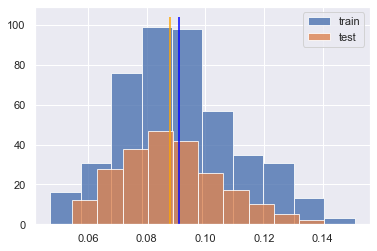

In [1108]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

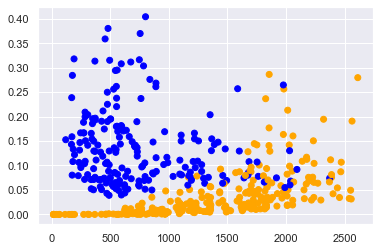

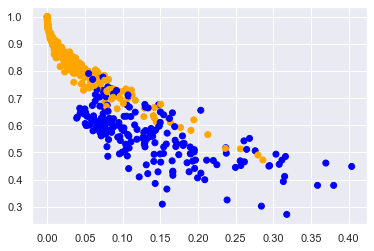

0.7215409934088653
0.08061426888056368
0.7314286549822419
0.06305234154384998


In [1109]:
pred_surv_bstr = bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv")
plt.scatter(y_tr["time"], metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_tr["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_tr["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))

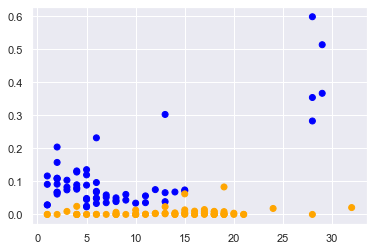

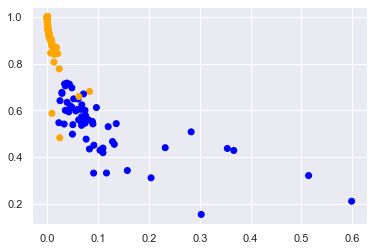

0.744015938790835
0.054686363183296116
0.7468746901946293
0.02173922439584937


In [517]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

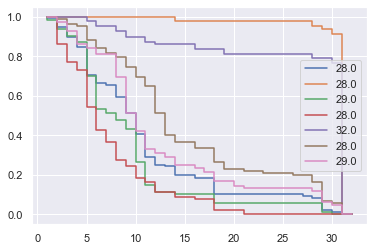

In [549]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")

for i in np.where(y_HO["time"] > 25)[0]:
    plt.step(bins_HO, pred_surv_bstr[i], label=y_HO["time"][i])

plt.legend()

In [547]:
X_HO[y_HO["time"] == 29]

,min_Prothrombin_time,min_fibrinogen,max____lymphocyte,min_HCV_antibody_quantification,max_White_blood_cell_count,min_neutrophils_count,max_Prothrombin_time,mean____lymphocyte,max_neutrophils_count,min_PLT_distribution_width,...,min_mean_corpuscular_hemoglobin_,mean_globulin,min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_,max_neutrophils___,min_monocytes_count,min_Mean_platelet_volume,max_Tumor_necrosis_factor_,min_Serum_chloride,max_Hypersensitive_cardiac_troponinI,mean_Uric_acid
342,17.4,0.79,6.2,0.08,32.99,7.16,20.0,4.033333,31.24,11.3,...,29.2,36.425,3251.0,95.0,0.14,10.3,11.3,97.1,8443.5,315.50
344,15.1,4.58,5.2,0.17,12.23,5.65,16.5,3.425000,11.13,16.7,...,31.3,30.150,362.0,93.6,0.16,12.0,NaN,113.5,14.4,228.25


In [548]:
bstr.models[0].visualize(mode="surv")

In [ ]:
[0.76148047 0.07352419 0.13980771 0.82946707 0.74286172 0.5305663
 0.72999533] # rank timeline

In [ ]:
[0.75421522 0.07813184 0.14888686 0.8335198  0.73483829 0.52543357
 0.72214709] # minstd full timeline

[0.76065798 0.07439718 0.14766853 0.85279943 0.7351438  0.52829684
 0.72260762] # minstd rank timeline

In [ ]:
[0.75188485 0.07409013 0.14285489 0.85783089 0.74401594 0.5302137
 0.73105823] # diptest full timeline

In [ ]:
[0.62220051 0.14063964 0.35077657 0.7636975  0.69013242 0.51602659
 0.67040949]

In [ ]:
[0.63251905 0.14106872 0.34654997 0.76467459 0.69642419 0.519807
 0.67641677]

In [177]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    print(peaks)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

max_width_peaks(np.histogram(data, bins=30)[0])

[ 7 21]


14

BC: 0.3097707514464615
diptest: 0.11607142857142858


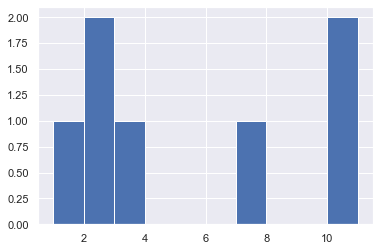

In [294]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skew, kurtosis

# Сгенерируем случайные данные
# data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(4, 1, 1000)])
x = np.array([1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1])
data = np.repeat(np.arange(1, x.size + 1), x.astype(int))

plt.hist(data)
sk = skew(data)
ku = kurtosis(data)
n = data.size

BC = (sk**2 + 1) / (ku + 3*((n - 1)**2 / ((n - 2) * (n - 3))))
print("BC:", BC)
print("diptest:", diptest.dipstat(data))
# # Построим гистограмму
# plt.hist(data, bins=30)

# print(max_width_peaks(np.histogram(data, bins=30)[0]))

In [153]:
peaks

array([2, 7], dtype=int64)

In [ ]:
[0.75243317 0.07333642 0.13933905 0.8614329  0.74303577 0.52134847
 0.72960017]

In [ ]:
[0.74996573 0.07691214 0.14588498 0.85021201 0.74433642 0.52095168
 0.73079795]

In [ ]:
[0.76422207 0.06826685 0.13153203 0.89333202 0.75438083 0.53143861
 0.74086918]

[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]

In [ ]:
[0.75668266 0.07506964 0.13524413 0.80499555 0.74893613 0.52512688
 0.73537194]

[0.75695682 0.07440272 0.14538163 0.85218725 0.74779245 0.52774081
 0.73445599]

In [ ]:
[0.75791638 0.07364925 0.13941104 0.84413016 0.74317018 0.52911454
 0.73019711]

[0.76004112 0.0753898  0.14509276 0.83574934 0.74281228 0.52814724
 0.72980227]

In [ ]:
[0.77930089 0.07105522 0.13704887 0.85401808 0.7516657  0.52669224
 0.73803095]

In [ ]:
[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]



In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]
[0.7540096  0.07487264 0.13640897 0.87782645 0.74885486 0.52464159
 0.73526618]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]

In [ ]:
[0.7540096  0.07479226 0.13625052 0.87836153 0.74900861 0.52494637
 0.73542908]

In [ ]:
[0.74002742 0.07227528 0.13196277 0.86458745 0.74718982 0.52254975
 0.73357527]

In [ ]:
[0.75531186 0.07359772 0.14559497 0.85845047 0.74459797 0.52122024
 0.73105993]

In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62802423 0.14211188 0.34170921 0.75739075 0.69467389 0.51757682
 0.67461211]

In [ ]:
[0.63107289 0.14144822 0.3462126  0.77005228 0.6896938  0.51910505
 0.67036929]

In [ ]:
[0.63056478 0.14079638 0.34322143 0.76938389 0.69300919 0.51992004
 0.67340143]

In [ ]:
[0.63146375 0.14081558 0.34032002 0.76382246 0.6913002  0.51914928
 0.67179873]

In [ ]:
[0.62364667 0.14340442 0.34647329 0.77301765 0.69317095 0.51897566
 0.67343789]

In [ ]:
[0.63306625 0.13905343 0.37198661 0.78508546 0.68627601 0.52907648
 0.66846826]

In [ ]:
[0.6214188  0.14391302 0.35822151 0.76261641 0.68925319 0.51655777
 0.66969004]

In [ ]:
[0.63162009 0.14071645 0.34137235 0.76280546 0.69149669 0.51923545
 0.67198272]